# Titanic - Machine Learning from Disaster
### The task is to create a model that predicts which passengers survived the Titanic shipwreck

## 1. Importing Libraries and Dataset

#### 1.1 Importing Libraries

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, GridSearchCV

#### 1.2 Loading Dataset

In [186]:
df_train = pd.read_csv("titanic/train.csv")
df_test = pd.read_csv("titanic/test.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Feature Engineering

Firstly i want to check, how many examples of Survived/Not Survived data are there in the training DataSet

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

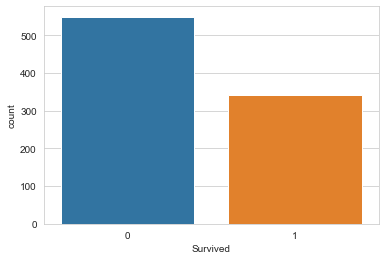

In [187]:
sns.countplot(df_train.Survived)

In [188]:
print(f"Survived - {df_train.Survived.loc[df_train.Survived == 1].count()}, Not Survived - {df_train.Survived.loc[df_train.Survived == 0].count()}")

Survived - 342, Not Survived - 549


There are enough instances of both cases

Let's check how many Categorical/Numerical features do we have

In [189]:
NumericalData = len(df_train.select_dtypes('number').columns)
CategoricalData = len(df_train.select_dtypes(exclude='number').columns)

print(f"Numerical Features - {NumericalData}, Categorical Features - {CategoricalData}")

Numerical Features - 7, Categorical Features - 5


#### 2.1 Missing Values Handling

In [190]:
train_null = df_train.isna().sum()
test_null = df_test.isna().sum()
missing = pd.DataFrame(
              data=[train_null, train_null/df_train.shape[0]*100,
                    test_null, test_null/df_test.shape[0]*100],
              columns=df_train.columns,
              index=["Train Null", "Train Null (%)", "Test Null", "Test Null (%)"]
          ).T.sort_values(["Train Null", "Test Null"], ascending=False)

In [191]:
# Filter only columns with missing values
missing = missing.loc[(missing["Train Null"] > 0) | (missing["Test Null"] > 0)]
missing

,Train Null,Train Null (%),Test Null,Test Null (%)
Cabin,687.0,77.104377,327.0,78.229665
Age,177.0,19.865320,86.0,20.574163
Embarked,2.0,0.224467,0.0,0.000000
Fare,0.0,0.000000,1.0,0.239234


There are a lot of missing values in Cabin and Age, let's handle it

For feature Cabin, 77% of the data is NaN, so I've decided to delete this column

In [192]:
df_train = df_train.drop(columns=["Cabin"])
df_test = df_test.drop(columns=["Cabin"])

There is one missing value for feature "Fare" in the Test Set. I'm going to replace it by median value

In [193]:
df_test.Fare.fillna(df_test.Fare.median(), inplace=True)

In [195]:
df_train = df_train.dropna(subset=["Embarked"])

Now let's deal with the feature "Age". It would be reasonable to look at Age distribution depending on ticket class, because younger people tend to have a lower income and therefore, they have tickets in a lower class. Thus, the older the person, the higher class he can afford.

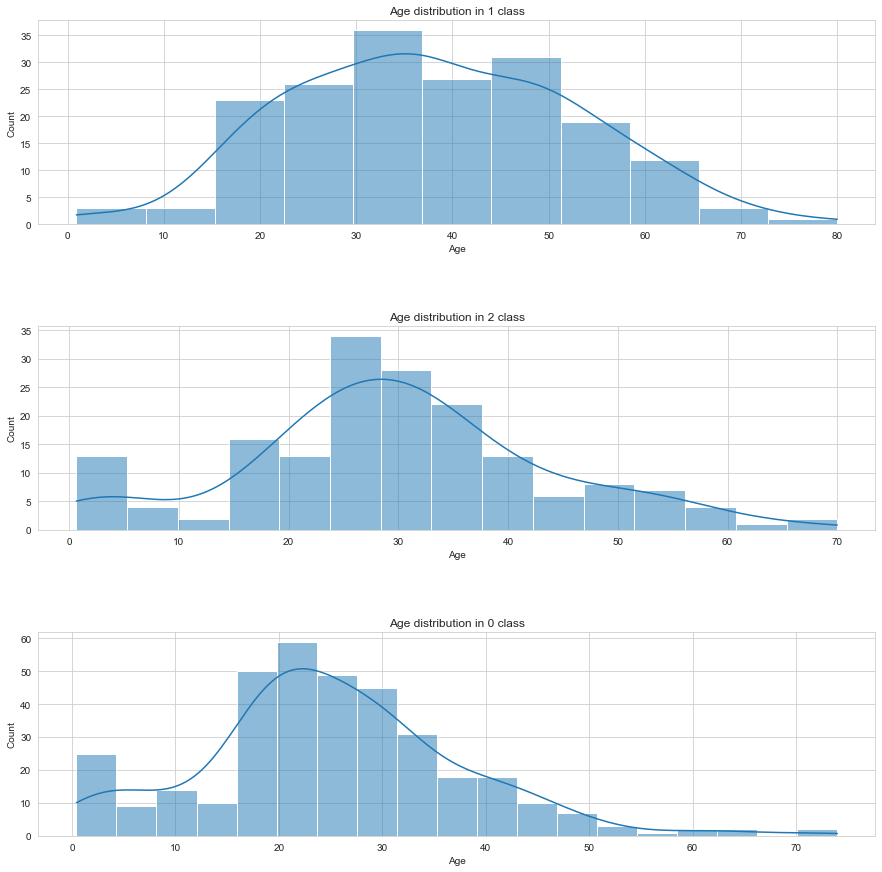

In [298]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax = ax.flatten()

for i in range(3):

    sns.histplot(data=df_train.Age.loc[(df_train.Age.isna()==False) & (df_train.Pclass==i+1)], kde=True, ax=ax[i])
    ax[i-1].set_title(f"Age distribution in {i} class")

plt.subplots_adjust(hspace=0.5)
plt.show()

As we can see, the data is skewed to right, so I'll replace missing values in Age by the median depending on ticket class of a passenger.

In [299]:
first_class_mean = df_train.loc[df_train.Pclass == 1].Age.median()
second_class_mean = df_train.loc[df_train.Pclass == 2].Age.median()
third_class_mean = df_train.loc[df_train.Pclass == 3].Age.median()